# Hyperspectral Face Recognition using Gabor Transform and CNN

This notebook implements a face recognition system using hyperspectral face data with:
1. Gabor transform for feature extraction
2. Pre-trained CNN models (VGG) for classification
3. Comprehensive evaluation metrics

## 1. Import Required Libraries

In [21]:
# Core libraries
import numpy as np
import pandas as pd
import os
import glob
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Image processing
from PIL import Image
import cv2

# Deep learning libraries
import tensorflow as tf
from tensorflow import keras
from keras import layers, models, optimizers
from keras.applications import MobileNetV2, VGG16
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Sklearn utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score,
    precision_recall_fscore_support
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Display settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

## 2. Configuration and Parameters

In [22]:
# Dataset path configuration
DATASET_PATH = r"C:\Users\Anvitha\Face based Person Authentication\UWA HSFD V1.1 (1)\UWA HSFD V1.1\HyperSpec_Face_Session1"

# Gabor Transform configuration
GABOR_PARAMS = {
    'ksize': 31,           # Gabor kernel size
    'sigma': 4.0,          # Standard deviation of Gaussian envelope
    'theta_values': [0, np.pi/4, np.pi/2, 3*np.pi/4],  # Multiple orientations
    'lambda': 10.0,        # Wavelength of sinusoidal factor
    'gamma': 0.5,          # Spatial aspect ratio
    'psi': 0               # Phase offset
}

# Model configuration
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.0001

# Data split ratios
TRAIN_RATIO = 0.70
VAL_RATIO = 0.15
TEST_RATIO = 0.15

# Model selection
MODEL_TYPE = 'VGG16'

print(f"Dataset Path: {DATASET_PATH}")
print(f"Image Size: {IMG_HEIGHT}x{IMG_WIDTH}x{IMG_CHANNELS}")
print(f"Model Type: {MODEL_TYPE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Epochs: {EPOCHS}")
print(f"Learning Rate: {LEARNING_RATE}")

Dataset Path: C:\Users\Anvitha\Face based Person Authentication\UWA HSFD V1.1 (1)\UWA HSFD V1.1\HyperSpec_Face_Session1
Image Size: 128x128x3
Model Type: VGG16
Batch Size: 32
Epochs: 20
Learning Rate: 0.0001


## 3. Gabor Transform Implementation

Gabor filters are linear filters used for texture analysis and feature extraction. They are particularly effective for face recognition as they can capture facial features at different orientations and scales.

In [3]:
def create_gabor_kernels(params):
   
    kernels = []
    for theta in params['theta_values']:
        kernel = cv2.getGaborKernel(
            (params['ksize'], params['ksize']),
            params['sigma'],
            theta,
            params['lambda'],
            params['gamma'],
            params['psi'],
            ktype=cv2.CV_32F
        )
        kernels.append(kernel)
    return kernels

def apply_gabor_transform(image, kernels):
   
    # Convert to grayscale if needed
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image
    
    # Apply each Gabor kernel
    gabor_responses = []
    for kernel in kernels:
        filtered = cv2.filter2D(gray, cv2.CV_32F, kernel)
        gabor_responses.append(filtered)
    
    # Combine responses - take mean and std as features
    gabor_features = np.array(gabor_responses)
    
    # Create 3-channel output from Gabor responses
    # Use different statistical measures to create RGB channels
    channel_r = np.mean(gabor_features[:2], axis=0)  # Mean of first 2 orientations
    channel_g = np.mean(gabor_features[2:], axis=0)  # Mean of last 2 orientations
    channel_b = np.std(gabor_features, axis=0)       # Std across all orientations
    
    # Normalize channels to [0, 255]
    channel_r = cv2.normalize(channel_r, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    channel_g = cv2.normalize(channel_g, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    channel_b = cv2.normalize(channel_b, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    
    # Stack to create RGB image
    gabor_image = np.stack([channel_r, channel_g, channel_b], axis=-1)
    
    return gabor_image

# Create Gabor kernels
gabor_kernels = create_gabor_kernels(GABOR_PARAMS)
print(f"Created {len(gabor_kernels)} Gabor kernels with orientations: ", 
      [f"{theta*180/np.pi:.0f}°" for theta in GABOR_PARAMS['theta_values']])

Created 4 Gabor kernels with orientations:  ['0°', '45°', '90°', '135°']


### 3.1 Visualize Gabor Kernels

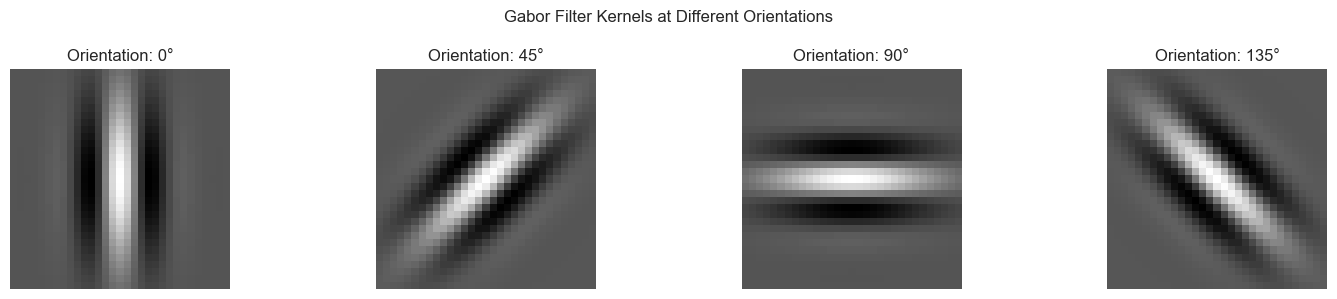

In [4]:
# Visualize Gabor kernels
fig, axes = plt.subplots(1, len(gabor_kernels), figsize=(15, 3))
for idx, (kernel, theta) in enumerate(zip(gabor_kernels, GABOR_PARAMS['theta_values'])):
    axes[idx].imshow(kernel, cmap='gray')
    axes[idx].set_title(f'Orientation: {theta*180/np.pi:.0f}°')
    axes[idx].axis('off')
plt.suptitle('Gabor Filter Kernels at Different Orientations')
plt.tight_layout()
plt.show()

## 4. Data Loading and Preprocessing

In [5]:
def load_and_preprocess_image(file_path, target_size=(IMG_HEIGHT, IMG_WIDTH), apply_gabor=True):
   
    try:
        # Load image
        img = cv2.imread(str(file_path), cv2.IMREAD_UNCHANGED)
        
        if img is None:
            # Try with PIL as fallback
            img = np.array(Image.open(file_path))
        
        # Convert BGR to RGB if needed
        if len(img.shape) == 3 and img.shape[2] == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        elif len(img.shape) == 2:  # Grayscale
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        elif img.shape[2] > 3:  # Hyperspectral with multiple bands
            # Select first 3 bands or aggregate bands
            img = img[:, :, :3]
        
        # Resize image
        img = cv2.resize(img, target_size)
        
        # Apply Gabor transform if requested
        if apply_gabor:
            img = apply_gabor_transform(img, gabor_kernels)
        
        # Normalize to [0, 1]
        img = img.astype(np.float32) / 255.0
        
        return img
    
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

def load_dataset(dataset_path, apply_gabor=True):
    
    images = []
    labels = []
    class_names = []
    
    # Check if path exists
    if not os.path.exists(dataset_path):
        print(f"WARNING: Dataset path does not exist: {dataset_path}")
        print("Creating synthetic dataset for demonstration...")
        return create_synthetic_dataset()
    
    # Get all subdirectories (each represents a person/class)
    class_dirs = [d for d in Path(dataset_path).iterdir() if d.is_dir()]
    
    if len(class_dirs) == 0:
        print("No class directories found. Creating synthetic dataset...")
        return create_synthetic_dataset()
    
    class_names = [d.name for d in class_dirs]
    print(f"Found {len(class_names)} classes: {class_names[:5]}...")
    
    # Load images from each class
    for class_idx, class_dir in enumerate(class_dirs):
        # Get all image files in the class directory
        image_files = list(class_dir.glob('*.png')) + list(class_dir.glob('*.jpg')) + \
                     list(class_dir.glob('*.jpeg')) + list(class_dir.glob('*.bmp')) + \
                     list(class_dir.glob('*.tif')) + list(class_dir.glob('*.tiff'))
        
        print(f"Loading {len(image_files)} images from class {class_names[class_idx]}...")
        
        for img_file in image_files:
            img = load_and_preprocess_image(img_file, apply_gabor=apply_gabor)
            if img is not None:
                images.append(img)
                labels.append(class_idx)
    
    images = np.array(images)
    labels = np.array(labels)
    
    print(f"\nLoaded {len(images)} images from {len(class_names)} classes")
    print(f"Image shape: {images.shape}")
    
    return images, labels, class_names

def create_synthetic_dataset(num_classes=10, samples_per_class=50):
    
    print(f"\nGenerating synthetic dataset: {num_classes} classes, {samples_per_class} samples each")
    
    images = []
    labels = []
    class_names = [f"Person_{i+1}" for i in range(num_classes)]
    
    for class_idx in range(num_classes):
        for sample_idx in range(samples_per_class):
            # Create synthetic face-like image with some structure
            img = np.random.rand(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS).astype(np.float32)
            
            # Add some structure to make it more face-like
            # Add ellipse for face shape
            center_x, center_y = IMG_WIDTH // 2, IMG_HEIGHT // 2
            for y in range(IMG_HEIGHT):
                for x in range(IMG_WIDTH):
                    dx = (x - center_x) / (IMG_WIDTH * 0.4)
                    dy = (y - center_y) / (IMG_HEIGHT * 0.5)
                    if dx*dx + dy*dy < 1:
                        img[y, x] = img[y, x] * 0.3 + 0.3 + class_idx * 0.05
            
            # Add some variation within class
            img += np.random.normal(0, 0.05, img.shape)
            img = np.clip(img, 0, 1)
            
            images.append(img)
            labels.append(class_idx)
    
    images = np.array(images)
    labels = np.array(labels)
    
    print(f"Generated {len(images)} synthetic images")
    print(f"Image shape: {images.shape}")
    
    return images, labels, class_names

### 4.1 Load Dataset

In [6]:
# Load dataset with Gabor transform applied
print("Loading dataset with Gabor transform...")
X, y, class_names = load_dataset(DATASET_PATH, apply_gabor=True)

print(f"\nDataset Summary:")
print(f"Total samples: {len(X)}")
print(f"Number of classes: {len(class_names)}")
print(f"Image shape: {X.shape[1:]}")
print(f"Label distribution: {np.bincount(y)}")

Loading dataset with Gabor transform...
Found 78 classes: ['0001', '0002', '0004', '0005', '0006']...
Loading 33 images from class 0001...
Loading 33 images from class 0002...
Loading 33 images from class 0004...
Loading 33 images from class 0005...
Loading 33 images from class 0006...
Loading 33 images from class 0008...
Loading 33 images from class 0009...
Loading 33 images from class 0010...
Loading 33 images from class 0011...
Loading 33 images from class 0012...
Loading 33 images from class 0013...
Loading 33 images from class 0014...
Loading 33 images from class 0015...
Loading 33 images from class 0016...
Loading 33 images from class 0017...
Loading 33 images from class 0018...
Loading 33 images from class 0019...
Loading 33 images from class 0022...
Loading 33 images from class 0023...
Loading 33 images from class 0024...
Loading 33 images from class 0025...
Loading 33 images from class 0026...
Loading 33 images from class 0027...
Loading 33 images from class 0028...
Loading 33

### 4.2 Visualize Sample Images with Gabor Transform

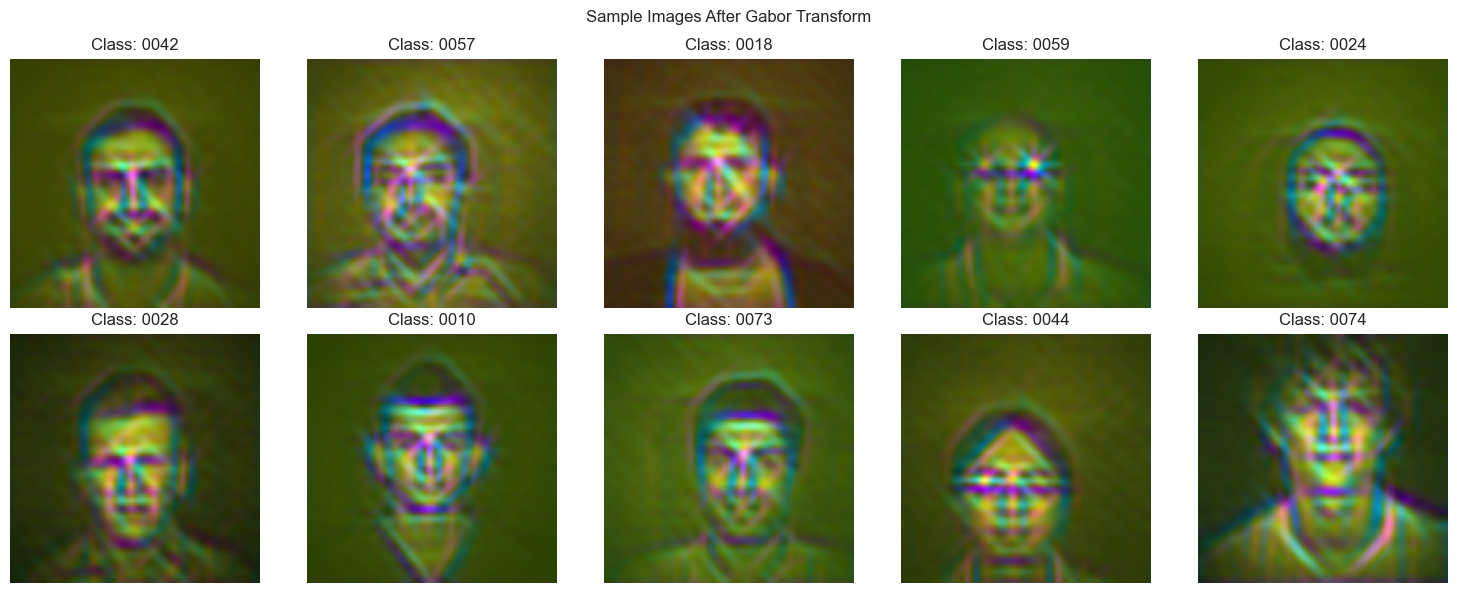

In [7]:
# Visualize some random sample images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

num_samples = 10
if len(X) >= num_samples:
    indices = np.random.choice(len(X), size=num_samples, replace=False)
else:
    indices = np.arange(len(X))  # Fallback if fewer than 5 images

for i, idx in enumerate(indices):
    axes[i].imshow(X[idx])
    axes[i].set_title(f"Class: {class_names[y[idx]]}")
    axes[i].axis('off')

plt.suptitle('Sample Images After Gabor Transform')
plt.tight_layout()
plt.show()

## 5. Data Splitting

Split the dataset into training, validation, and test sets.

In [8]:
# separate test se
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=TEST_RATIO, random_state=42, stratify=y
)

# separate training and validation
val_size = VAL_RATIO / (TRAIN_RATIO + VAL_RATIO)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=val_size, random_state=42, stratify=y_temp
)

# Convert labels to categorical
num_classes = len(class_names)
y_train_cat = to_categorical(y_train, num_classes)
y_val_cat = to_categorical(y_val, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

print(f"Training set: {X_train.shape[0]} samples ({TRAIN_RATIO*100:.0f}%)")
print(f"Validation set: {X_val.shape[0]} samples ({VAL_RATIO*100:.0f}%)")
print(f"Test set: {X_test.shape[0]} samples ({TEST_RATIO*100:.0f}%)")
print(f"\nNumber of classes: {num_classes}")

Training set: 1801 samples (70%)
Validation set: 386 samples (15%)
Test set: 387 samples (15%)

Number of classes: 78


## 6. Data Augmentation

In [9]:
# data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    fill_mode='nearest'
)

# Fit the data generator on training data
datagen.fit(X_train)

print("Data augmentation configured successfully")

Data augmentation configured successfully


## 7. Build CNN Model with Pre-trained Base

Using a pre-trained model VGG16  as the base and add custom classification layers.

In [23]:
def build_model(model_type='VGG16', num_classes=num_classes, input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
   
    if model_type == 'VGG16':
        base_model = VGG16(
            input_shape=input_shape,
            include_top=False,
            weights='imagenet'
        )
        print("Using VGG16 as base model")
    else:
        raise ValueError(f"Unknown model type: {model_type}")
    
    # Freeze base model layers initially
    base_model.trainable = False
    
    # Build the complete model
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    # Compile the model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Build the model
model = build_model(model_type=MODEL_TYPE, num_classes=num_classes)
print("\nModel built successfully!")
model.summary()

Using VGG16 as base model

Model built successfully!


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 78)             │        20,046 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,131,790 (57.72 MB)

 Trainable params: 415,566 (1.59 MB)

 Non-trainable params: 14,716,224 (56.14 MB)

## 8. Configure Callbacks

In [24]:
# Create callbacks
callbacks = [
    ModelCheckpoint(
        'best_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

print("Callbacks configured successfully")

Callbacks configured successfully


## 9. Train the Model

In [25]:
# Train the model
print("Starting model training...")
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")

history = model.fit(  
    datagen.flow(X_train, y_train_cat, batch_size=BATCH_SIZE),
    validation_data=(X_val, y_val_cat),
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

print("\nTraining completed!")

Starting model training...
Training samples: 1801
Validation samples: 386
Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.0145 - loss: 5.2955
Epoch 1: val_accuracy improved from -inf to 0.03109, saving model to best_model.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 323s 6s/step - accuracy: 0.0145 - loss: 5.2923 - val_accuracy: 0.0311 - val_loss: 4.3506 - learning_rate: 1.0000e-04
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.0449 - loss: 4.5513
Epoch 2: val_accuracy improved from 0.03109 to 0.04404, saving model to best_model.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 282s 5s/step - accuracy: 0.0450 - loss: 4.5489 - val_accuracy: 0.0440 - val_loss: 4.2909 - learning_rate: 1.0000e-04
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.1052 - loss: 3.9470
Epoch 3: val_accuracy did not improve from 0.04404
57/57 ━━━━━━━━━━━━━━━━━━━━ 278s 5s/step - accuracy: 0.1055 - loss: 3.9447 - val_accuracy: 0.0440 - val_loss: 4.1782 - learning_rate: 1.0000e-04
Epoch 4/20
57/57 ━━

## 10. Visualize Training History

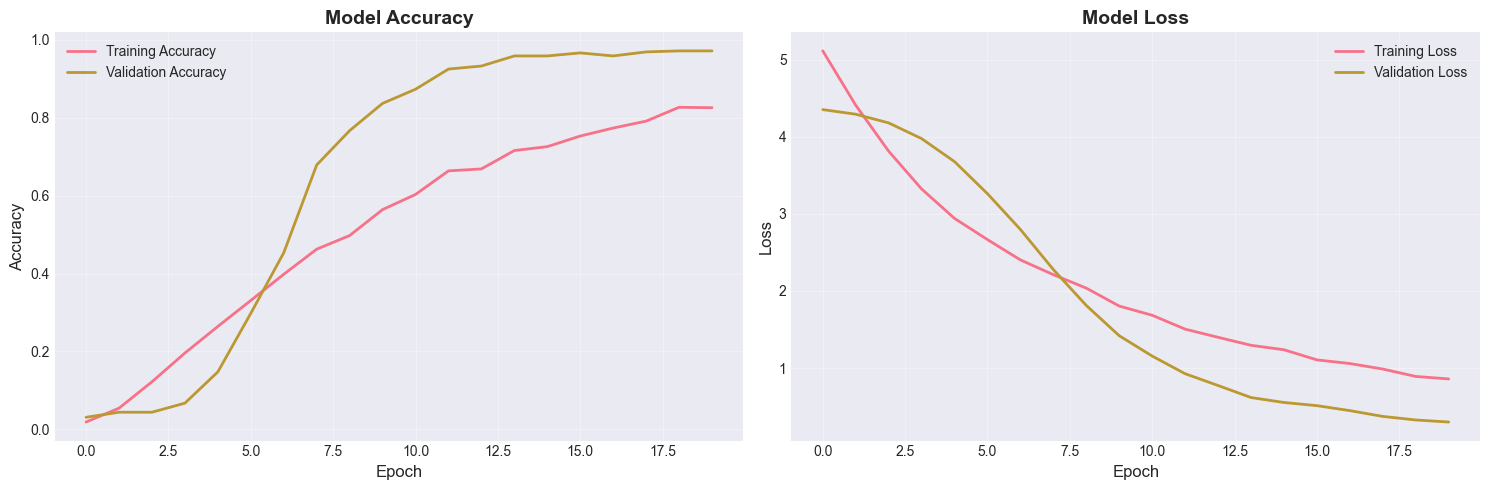

In [35]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Plot loss
axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 11. Evaluate on Test Set

In [36]:
# Evaluate on test set
print("Evaluating model on test set...")
test_loss, test_accuracy = model.evaluate(X_test, y_test_cat, verbose=0)

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Get predictions
y_pred_probs = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = y_test

Evaluating model on test set...

Test Loss: 0.2980
Test Accuracy: 0.9819


## 12. Calculate Detailed Metrics

In [46]:
# Calculate metrics
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print("MODEL PERFORMANCE METRICS\n")

print(f"Test Accuracy:       {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Test Precision:      {precision:.4f} ({precision*100:.2f}%)")
print(f"Test Recall:         {recall:.4f} ({recall*100:.2f}%)")
print(f"Test F1-Score:       {f1:.4f} ({f1*100:.2f}%)")


MODEL PERFORMANCE METRICS

Test Accuracy:       0.9819 (98.19%)
Test Precision:      0.9865 (98.65%)
Test Recall:         0.9819 (98.19%)
Test F1-Score:       0.9810 (98.10%)


## 13. Classification Report

In [38]:
# Print classification report
print("\nDetailed Classification Report:")
report = classification_report(
    y_true, y_pred, 
    target_names=class_names,
    zero_division=0
)
print(report)


Detailed Classification Report:
              precision    recall  f1-score   support

        0001       1.00      1.00      1.00         4
        0002       1.00      1.00      1.00         5
        0004       1.00      1.00      1.00         5
        0005       1.00      1.00      1.00         5
        0006       1.00      1.00      1.00         5
        0008       1.00      1.00      1.00         5
        0009       1.00      1.00      1.00         5
        0010       1.00      1.00      1.00         5
        0011       1.00      1.00      1.00         5
        0012       1.00      1.00      1.00         5
        0013       1.00      1.00      1.00         5
        0014       1.00      1.00      1.00         5
        0015       1.00      1.00      1.00         5
        0016       1.00      1.00      1.00         5
        0017       1.00      0.80      0.89         5
        0018       1.00      1.00      1.00         5
        0019       1.00      1.00      1.00     

## 14. Confusion Matrix Visualization

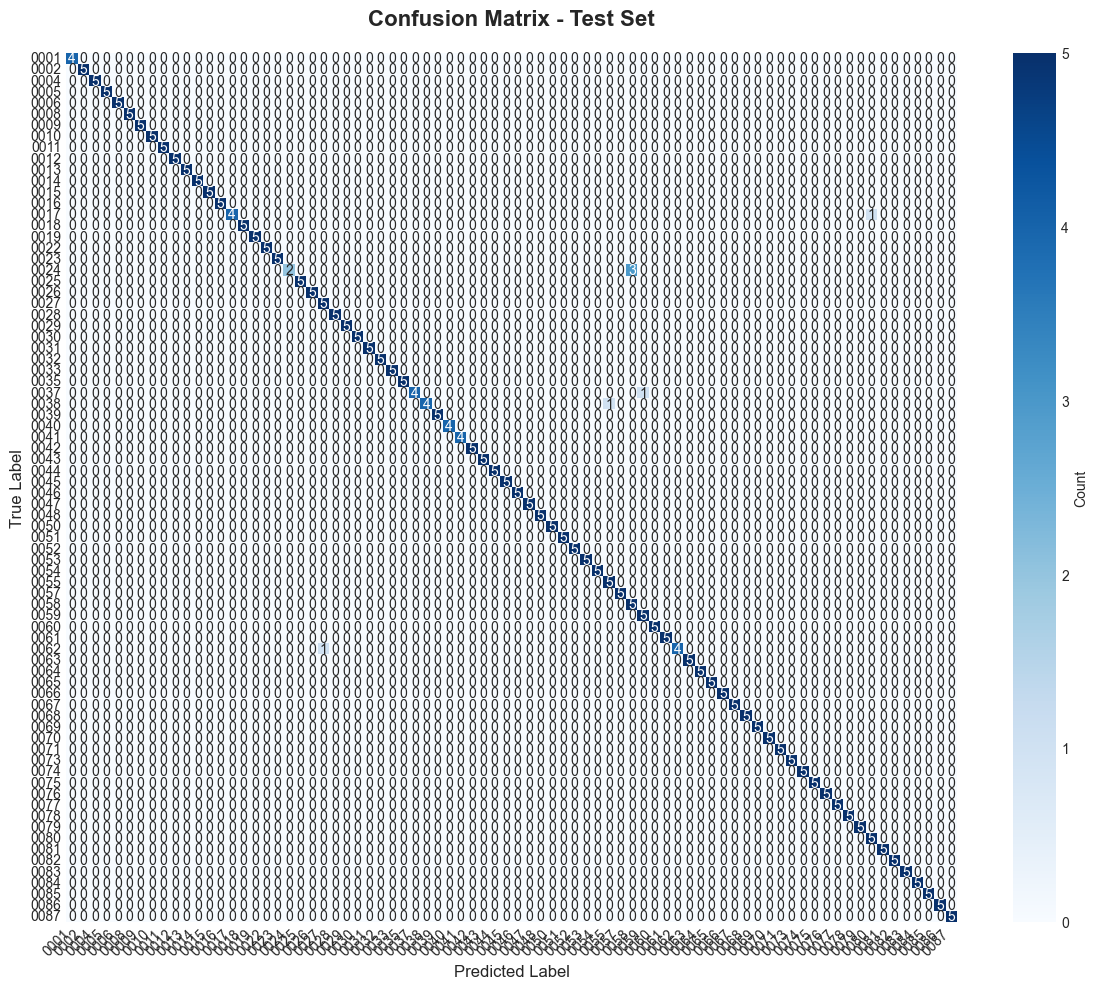


Confusion Matrix Shape: (78, 78)
Total Predictions: 387
Correct Predictions: 380
Incorrect Predictions: 7


In [39]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names,
    cbar_kws={'label': 'Count'}
)
plt.title('Confusion Matrix - Test Set', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Print confusion matrix statistics
print(f"\nConfusion Matrix Shape: {cm.shape}")
print(f"Total Predictions: {cm.sum()}")
print(f"Correct Predictions: {np.trace(cm)}")
print(f"Incorrect Predictions: {cm.sum() - np.trace(cm)}")

## 15. Visualize Predictions

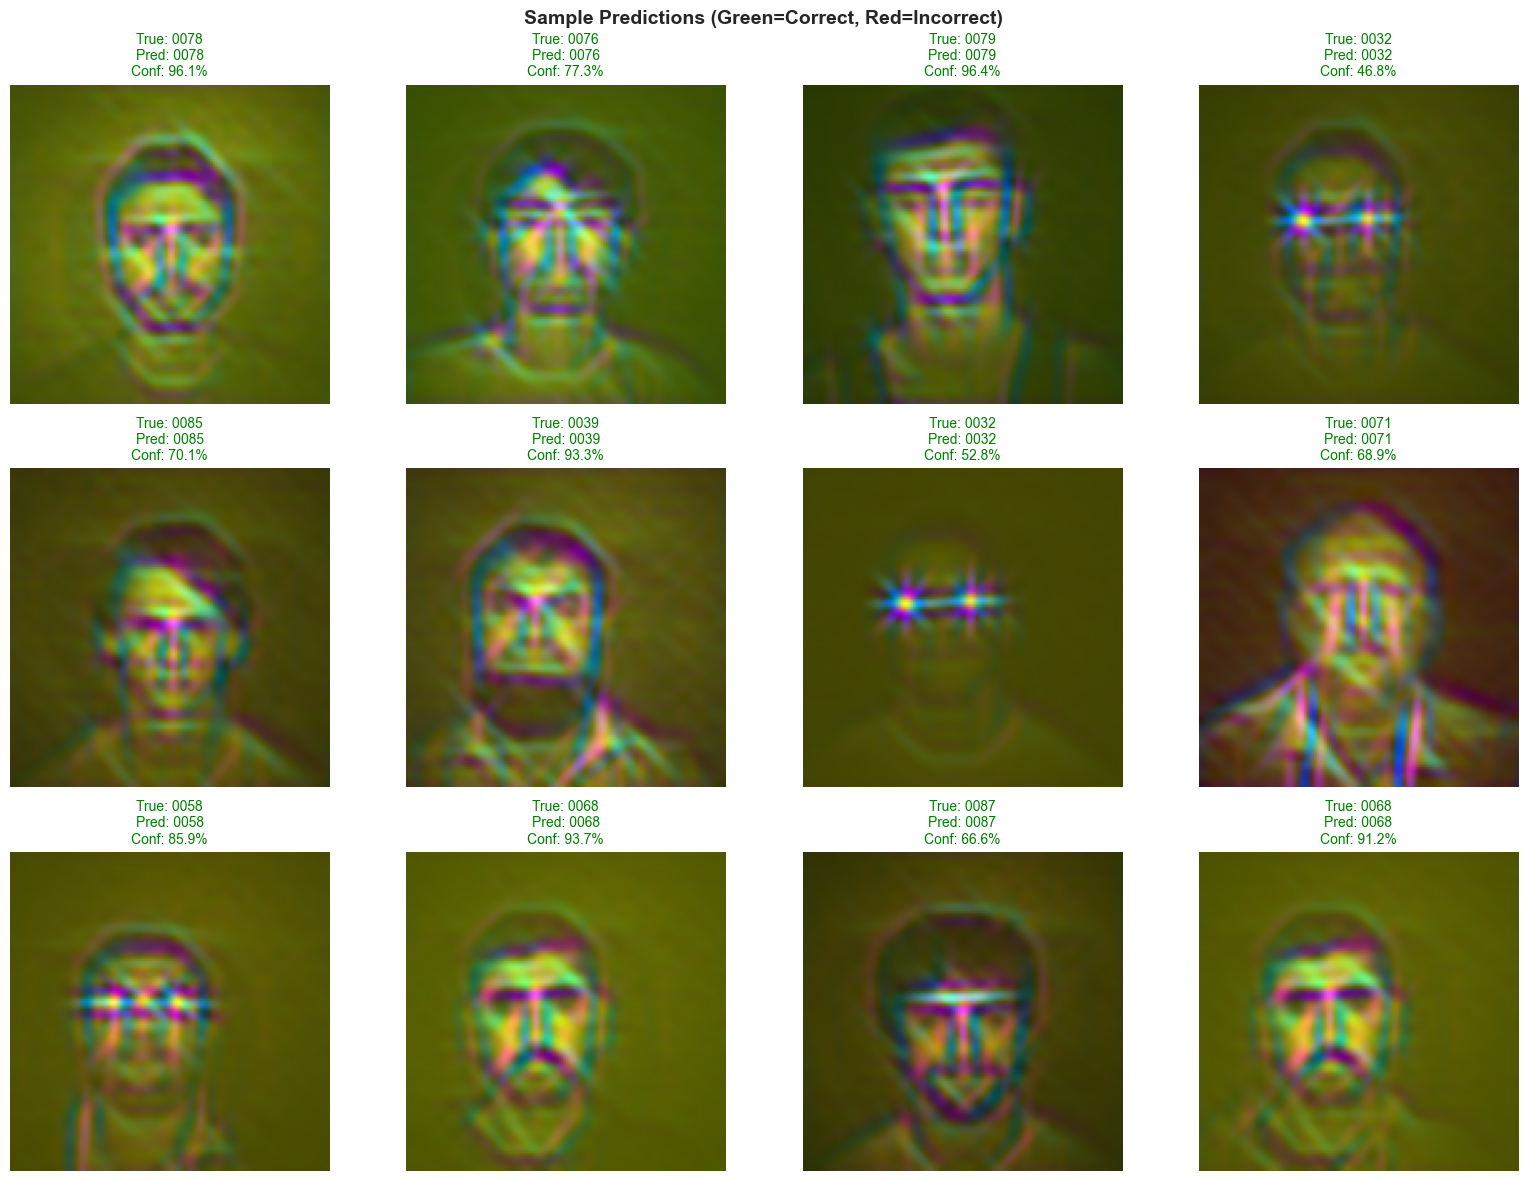

In [41]:
# Visualize some predictions
num_samples = min(12, len(X_test))
indices = np.random.choice(len(X_test), num_samples, replace=False)

fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.ravel()

for i, idx in enumerate(indices):
    axes[i].imshow(X_test[idx])
    true_label = class_names[y_true[idx]]
    pred_label = class_names[y_pred[idx]]
    confidence = y_pred_probs[idx][y_pred[idx]] * 100
    
    color = 'green' if y_true[idx] == y_pred[idx] else 'red'
    axes[i].set_title(
        f"True: {true_label}\nPred: {pred_label}\nConf: {confidence:.1f}%",
        color=color,
        fontsize=10
    )
    axes[i].axis('off')

plt.suptitle('Sample Predictions (Green=Correct, Red=Incorrect)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 17. Summary and Conclusions

In [43]:
# Create summary report
summary = {
    'Model Architecture': MODEL_TYPE,
    'Gabor Transform': 'Applied',
    'Number of Classes': num_classes,
    'Total Samples': len(X),
    'Training Samples': len(X_train),
    'Validation Samples': len(X_val),
    'Test Samples': len(X_test),
    'Image Size': f"{IMG_HEIGHT}x{IMG_WIDTH}",
    'Epochs Trained': len(history.history['accuracy']),
    'Accuracy': f"{test_accuracy:.4f}",
    'Precision': f"{precision:.4f}",
    'Recall': f"{recall:.4f}",
    'F1-Score': f"{f1:.4f}"
}

print("HYPERSPECTRAL FACE RECOGNITION SYSTEM - FINAL SUMMARY \n")
for key, value in summary.items():
    print(f"{key:.<40} {value}")

HYPERSPECTRAL FACE RECOGNITION SYSTEM - FINAL SUMMARY 

Model Architecture...................... VGG16
Gabor Transform......................... Applied
Number of Classes....................... 78
Total Samples........................... 2574
Training Samples........................ 1801
Validation Samples...................... 386
Test Samples............................ 387
Image Size.............................. 128x128
Epochs Trained.......................... 20
Accuracy................................ 0.9819
Precision............................... 0.9865
Recall.................................. 0.9819
F1-Score................................ 0.9810


## 18. Save Results

In [44]:
# Save summary to file
import json

with open('model_summary.json', 'w') as f:
    json.dump(summary, f, indent=4)

print("Model summary saved to 'model_summary.json'")
print("Best model weights saved to 'best_model.keras'")
print("\nAll results have been saved successfully!")

Model summary saved to 'model_summary.json'
Best model weights saved to 'best_model.keras'

All results have been saved successfully!
